In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

# Load datasets

In [18]:
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_ds = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')


# Display the first few rows of the datasets

In [19]:
print(train_df.head())
print(test_ds.head())

         id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT

# Clean the training dataset

In [20]:
threshold = 0.5 * len(train_df)
valid_columns = train_df.columns[train_df.isnull().sum() < threshold]
train_df = train_df[valid_columns].fillna(0)

# Remove rows with missing target values

In [21]:
target_column = 'sii'
train_df_cleaned = train_df.dropna(subset=[target_column])

# Encode seasonal columns

In [22]:
pd.set_option('future.no_silent_downcasting', True)

# Encode seasonal columns
season_columns = [
    "Basic_Demos-Enroll_Season",
    "CGAS-Season",
    "Physical-Season",
    "FGC-Season",
    "BIA-Season",
    "PCIAT-Season",
    "SDS-Season",
    "PreInt_EduHx-Season",
]
season_values = {"Spring": 0, "Summer": 1, "Fall": 2, "Winter": 3}
for column in season_columns:
    if column in train_df_cleaned.columns:
        train_df_cleaned[column] = train_df_cleaned[column].replace(season_values)



# Extract features and target

In [23]:
common_features = train_df_cleaned.columns.intersection(test_ds.columns)
X = train_df_cleaned[common_features]
if "id" in X.columns:
    X = X.drop(columns=["id"])
y = train_df_cleaned["sii"]

# Split data into train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


# Scale numeric features

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction

In [26]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Build the neural network model

In [27]:
network_model = Sequential(
    [
        Input(shape=(X_train_pca.shape[1],)),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)


# Compile the model

In [28]:
network_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Set up callbacks

In [29]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
)

# Train the model

In [30]:
history = network_model.fit(
    X_train_pca,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_pca, y_test),
    callbacks=[lr_scheduler],
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5150 - loss: 0.6930 - val_accuracy: 0.6338 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6382 - loss: 0.4222 - val_accuracy: 0.6654 - val_loss: 0.3222 - learning_rate: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6645 - loss: 0.3204 - val_accuracy: 0.6780 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 0.1974 - val_accuracy: 0.6881 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.1882 - val_accuracy: 0.6780 - val_loss: 0.1777 - learning_rate: 0.0010
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.0216 - val_accuracy: 0.6982 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6793 - loss: 0.2139 - val_accuracy: 

# Evaluate the model

In [31]:
y_pred = network_model.predict(X_test_pca)
y_pred_class = (y_pred > 0.5).astype(int)
print(
    "Classification Report:\n",
    classification_report(y_test, y_pred_class, zero_division=1),
)
print(f"Accuracy: {accuracy_score(y_test, y_pred_class) * 100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       563
         1.0       0.35      0.65      0.45       141
         2.0       1.00      0.00      0.00        84
         3.0       1.00      0.00      0.00         4

    accuracy                           0.69       792
   macro avg       0.80      0.37      0.32       792
weighted avg       0.79      0.69      0.67       792

Accuracy: 69.07%


# Plot training and validation loss

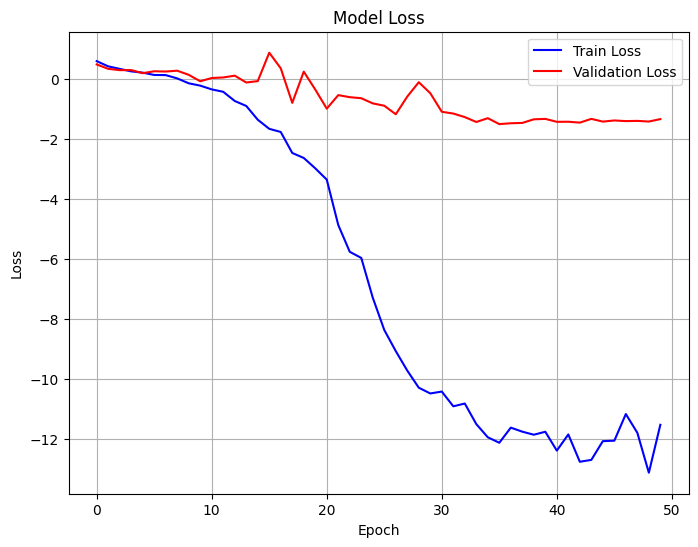

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy


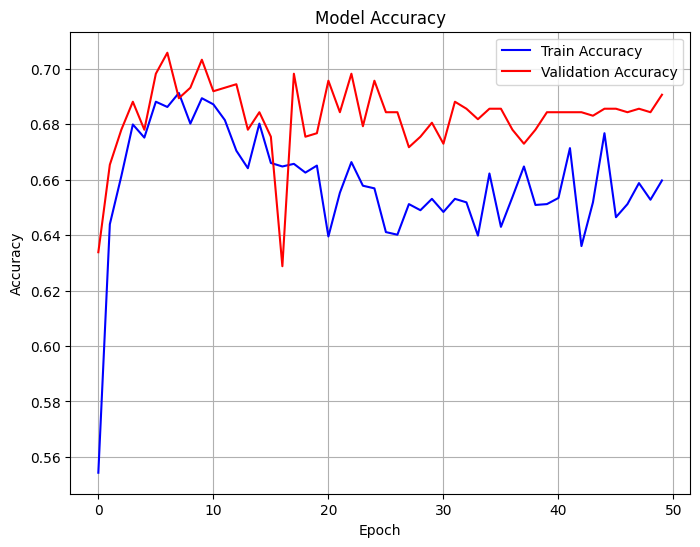

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="red")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Preprocess the test dataset


In [34]:
test_ds_cleaned = test_ds.fillna(0)


# Handle 'Season' columns in test dataset


In [35]:
pd.set_option('future.no_silent_downcasting', True)

# Encode seasonal columns
season_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'FGC-Season', 'BIA-Season', 
                  'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']
season_values = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
for column in season_columns:
    if column in test_ds_cleaned.columns:
        test_ds_cleaned[column] = test_ds_cleaned[column].replace(season_values)


# Ensure the test dataset has the same feature set as training


In [36]:
X_test_final = test_ds_cleaned[common_features]
if "id" in X_test_final.columns:
    ids = X_test_final["id"]
    X_test_final = X_test_final.drop(columns=["id"])

# Scale and apply PCA on test dataset


In [37]:
X_test_final_scaled = scaler.transform(X_test_final)
X_test_final_pca = pca.transform(X_test_final_scaled)

# Predict on test dataset


In [38]:
test_predictions = network_model.predict(X_test_final_pca)
test_predictions_class = (test_predictions > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


# Prepare submission


In [39]:
submission = pd.DataFrame({"id": ids, "sii": test_predictions_class.flatten()})
submission.to_csv("submission.csv", index=False)


print("Submission file 'submission.csv' has been created.")

Submission file 'submission.csv' has been created.
